# Multilabel Classifier : One vs All - Part 2

Author: Cristobal Zamorano Astudillo

The original repo of this project can be found [here](https://github.com/cristobalza/toxic_nlp_project). You can also find Part 1 and data in my personal repo.

**Goal**: Create a model that can predict for each toxic level.

Documentation:
```
Toxic: very bad, unpleasant, or harmful

Severe toxic: extremely bad and offensive

Obscene: (of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency

Threat: a statement of an intention to inflict pain, injury, damage, or other hostile action on someone in retribution for something done or not done

Insult: speak to or treat with disrespect or scornful abuse

Identity hate: hatred, hostility, or violence towards members of a race, ethnicity, nation, religion, gender, gender identity, sexual orientation or any other designated sector of society

```
*Source: [IBM Research](https://developer.ibm.com/technologies/artificial-intelligence/models/max-toxic-comment-classifier/)*

> The underlying neural network is based on the pre-trained BERT-Base, English Uncased model and was finetuned on the Toxic Comment Classification Dataset using the Huggingface BERT Pytorch repository. - IBM Team Approach.

For this project I did not want to use the same approach as the top Kaggle Competitors winners or the IBM Reasearch from above. I did not use any ver computational expensive models.

Rather the goal of this notebook is to create ways to test base models, improve them, and deploy them with binary code, so it can become a Machine Learning web app.


General Overview:

5. Model Selection
6. Ensemble Model Building and Hyperparameter Tuning (NOT FINISHED)
7. Test Model Results (Demo)
8. Deploy

In [1]:
import numpy as np
import pandas as pd
import re
import calendar

#visualizations
import matplotlib.style as style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import matplotlib.gridspec as gridspec 
import seaborn as sns
mpl.rcParams['figure.dpi']= 150
sns.mpl.rc("figure", figsize=(10, 6))
# grid: rgb(240,240,240)
# background: rgb(200,200,200)
style.use('fivethirtyeight')

In [2]:
# #nlp
# import string
# import re    #for regex
# import nltk
# from nltk.corpus import stopwords # remove useless words or words that do not add value
# from nltk.stem.lancaster import LancasterStemmer # Convert words to the infinitive form - very aggressive transformation.
# import spacy
# from nltk import pos_tag
# from nltk.stem.wordnet import WordNetLemmatizer 
# from nltk.tokenize import word_tokenize
# # Tweet tokenizer does not split at apostophes which is what we want
# from nltk.tokenize import TweetTokenizer

In [3]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Evaluate model performance
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, cross_validate, train_test_split, KFold

In [4]:
# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV # needed to predict_proba for svm family
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import RFE

# import xgboost as xgb
# import lightgbm as lgb

From Part 1, we download the cleaned and pre processed training data:

In [5]:
data_toxic_balanced = pd.read_csv('./data/output/pre_process_data/data_toxic_balanced.csv')
data_severe_toxic_balanced = pd.read_csv('./data/output/pre_process_data/data_severe_toxic_balanced.csv')
data_obscene_balanced = pd.read_csv('./data/output/pre_process_data/data_obscene_balanced.csv')
data_threat_balanced = pd.read_csv('./data/output/pre_process_data/data_threat_balanced.csv')
data_insult_balanced = pd.read_csv('./data/output/pre_process_data/data_insult_balanced.csv')
data_id_hate_balanced = pd.read_csv('./data/output/pre_process_data/data_id_hate_balanced.csv')

## 5. Model Selection

I will use Cross-Validation to select the best model.

In [10]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)

In [11]:
# Base model
lr = LogisticRegression(solver='lbfgs', max_iter=100)
# lr.fit(X_train_cv1, y_train)

# Base Model too. Inspire in this class semester
knn = KNeighborsClassifier(n_neighbors=5)

# ARGUABLY the best one vs all according to many posts such as this: https://sdsawtelle.github.io/blog/output/week7-andrew-ng-machine-learning-with-python.html
svm_model = LinearSVC()
svm_model_2 = CalibratedClassifierCV(svm_model)

# Standard powerful model
randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# I had good past experience with this one in another project
gb = GradientBoostingClassifier(random_state=42)

# Base Neural Network
mlp = MLPClassifier(random_state=42)

# Microsoft ALgorithm
# lg = lgb.LGBMClassifier(max_bin=4,
#                     num_iterations=550,
#                     learning_rate=0.0114,
#                     max_depth=3,
#                     num_leaves=7,
#                     colsample_bytree=0.35,
#                     random_state=42,
#                     n_jobs=-1)


# xg = xgb.XGBClassifier(
#     n_estimators=2800,
#     min_child_weight=0.1,
#     learning_rate=0.002,
#     max_depth=2,
#     subsample=0.47,
#     colsample_bytree=0.35,
#     gamma=0.4,
#     reg_lambda=0.4,
#     random_state=42,
#     n_jobs=-1,
# )

In [12]:
estimators = [lr,
             knn,
             svm_model_2,
             randomforest,
             gb,
             mlp
#               lg,
#               xg
             ]

## Cross-Validation Aproach:

For this approach I used k-split sklearn object. Instead of using a `KFold`, I used the `StratifiedKFold`. 
> Stratification is the process of rearranging the data as to ensure each fold is a good representative of the whole. For example in a binary classification problem where each class comprises 50% of the data, it is best to arrange the data such that in every fold, each class comprises around half the instances. - [KFold vs StratifiedKFold](https://xzz201920.medium.com/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf)

### Aproach #1:
- Step 1 : Split the data into X and y data sets
- Step 2 : Split our data into training and test data 
- Step 3 : Create a Vectorizer object 
- Step 4 : Create an empty DataFrame and a `row_index` counting variable
- Step 5 : Create a Cross-Validated Object using `cross_validate` from Sklearn. Calculate F1 Cross-validated metric.
- Step 6 : Sort the DataFrame values by the F1 Score


In [18]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    # Step 1: Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Step 2: Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 3: Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    # Learn the vocabulary dictionary and return term-document matrix
    X_train_cv1 = cv1.fit_transform(X_train) 
    # Learn a vocabulary dictionary of all tokens in the raw documents.
    X_test_cv1  = cv1.transform(X_test)      
    
    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
    # Step 4 : Create an empty DataFrame and a row_index counting variable
    model_df = pd.DataFrame()
    row_index_count = 0

    for est in estimators:
        # With the row index, input the name of the current Model
        model_df.loc[row_index_count, 'Model Name'] = est.__class__.__name__
        # Step 5 : Create a Cross-Validated Object using `cross_validate` from Sklearn 
        cv_results = cross_validate(
            est,
            X_train_cv1,
            y_train,
            cv=cv,
            scoring='f1',
            return_train_score=True,
            n_jobs=-1
        )
        # Input the F1 Score of prediction of each column
        model_df.loc[row_index_count, 'F1 Score'] = cv_results['train_score'].mean()
        row_index_count = row_index_count + 1
        
    # Step 6 : sort the DataFrame values by the F1 Score
    model_df.sort_values(by=['F1 Score'],
                            ascending=False,
                            inplace=True)
    
    return model_df

In [19]:
import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_toxic_balanced, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

Time taken: 854.6177761554718 seconds


,Model Name,F1 Score(toxic)
3,RandomForestClassifier,0.999711
5,MLPClassifier,0.999711
2,CalibratedClassifierCV,0.996939
0,LogisticRegression,0.947215
4,GradientBoostingClassifier,0.807415
1,KNeighborsClassifier,0.729866
6,LGBMClassifier,0.723090
7,XGBClassifier,0.692374


In [21]:
t0 = time.time()

df_sev_cv = cv_tf_train_test(data_severe_toxic_balanced, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

Time taken: 169.86274313926697 seconds


,Model Name,F1 Score(severe_toxic)
3,RandomForestClassifier,0.999551
5,MLPClassifier,0.998903
2,CalibratedClassifierCV,0.996462
0,LogisticRegression,0.969083
4,GradientBoostingClassifier,0.936072
6,LGBMClassifier,0.903036
7,XGBClassifier,0.869159
1,KNeighborsClassifier,0.711469


In [22]:
t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obscene_balanced, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

Time taken: 827.1422989368439 seconds


,Model Name,F1 Score(obscene)
3,RandomForestClassifier,0.999856
5,MLPClassifier,0.999278
2,CalibratedClassifierCV,0.997419
0,LogisticRegression,0.956692
4,GradientBoostingClassifier,0.880880
6,LGBMClassifier,0.836955
7,XGBClassifier,0.797823
1,KNeighborsClassifier,0.690330


In [23]:
t0 = time.time()

df_thr_cv = cv_tf_train_test(data_threat_balanced, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

Time taken: 106.33558392524719 seconds


,Model Name,F1 Score(threat)
3,RandomForestClassifier,1.000000
5,MLPClassifier,1.000000
2,CalibratedClassifierCV,0.999828
4,GradientBoostingClassifier,0.945889
1,KNeighborsClassifier,0.834564
6,LGBMClassifier,0.809115
7,XGBClassifier,0.778239
0,LogisticRegression,0.767986


In [24]:
t0 = time.time()

df_ins_cv = cv_tf_train_test(data_insult_balanced, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv


Time taken: 924.4053530693054 seconds


,Model Name,F1 Score(insult)
3,RandomForestClassifier,0.999439
5,MLPClassifier,0.999294
2,CalibratedClassifierCV,0.993415
0,LogisticRegression,0.952480
1,KNeighborsClassifier,0.869914
4,GradientBoostingClassifier,0.850832
6,LGBMClassifier,0.791688
7,XGBClassifier,0.748446


In [25]:

t0 = time.time()

df_ide_cv = cv_tf_train_test(data_id_hate_balanced, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

Time taken: 558.8539710044861 seconds


,Model Name,F1 Score(identity_hate)
3,RandomForestClassifier,0.999079
5,MLPClassifier,0.998616
2,CalibratedClassifierCV,0.989713
1,KNeighborsClassifier,0.912527
4,GradientBoostingClassifier,0.808305
0,LogisticRegression,0.767211
6,LGBMClassifier,0.713482
7,XGBClassifier,0.649222


In [28]:
# # Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
# f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
# f1_all

,Model Name,F1 Score(toxic),Model Name,F1 Score(severe_toxic),Model Name,F1 Score(obscene),Model Name,F1 Score(insult),Model Name,F1 Score(threat),Model Name,F1 Score(identity_hate)
0,LogisticRegression,0.947215,LogisticRegression,0.969083,LogisticRegression,0.956692,LogisticRegression,0.952480,LogisticRegression,0.767986,LogisticRegression,0.767211
1,KNeighborsClassifier,0.729866,KNeighborsClassifier,0.711469,KNeighborsClassifier,0.690330,KNeighborsClassifier,0.869914,KNeighborsClassifier,0.834564,KNeighborsClassifier,0.912527
2,CalibratedClassifierCV,0.996939,CalibratedClassifierCV,0.996462,CalibratedClassifierCV,0.997419,CalibratedClassifierCV,0.993415,CalibratedClassifierCV,0.999828,CalibratedClassifierCV,0.989713
3,RandomForestClassifier,0.999711,RandomForestClassifier,0.999551,RandomForestClassifier,0.999856,RandomForestClassifier,0.999439,RandomForestClassifier,1.000000,RandomForestClassifier,0.999079
4,GradientBoostingClassifier,0.807415,GradientBoostingClassifier,0.936072,GradientBoostingClassifier,0.880880,GradientBoostingClassifier,0.850832,GradientBoostingClassifier,0.945889,GradientBoostingClassifier,0.808305
5,MLPClassifier,0.999711,MLPClassifier,0.998903,MLPClassifier,0.999278,MLPClassifier,0.999294,MLPClassifier,1.000000,MLPClassifier,0.998616
6,LGBMClassifier,0.723090,LGBMClassifier,0.903036,LGBMClassifier,0.836955,LGBMClassifier,0.791688,LGBMClassifier,0.809115,LGBMClassifier,0.713482
7,XGBClassifier,0.692374,XGBClassifier,0.869159,XGBClassifier,0.797823,XGBClassifier,0.748446,XGBClassifier,0.778239,XGBClassifier,0.649222


### Results - Aproach #1:

- It seems that the training results were overfitted.
- Add `model.__class__.__name__` to the index instead of making a new feature.
- Need to try a different way.

## `TfidfVectorizer` vs `CountVectorizer`

Instead of aproaching another Cross-Validation, I split the data and test the raw F1 Score using different text data pre processors.

Idea is to compare the same models, but with different text data vector pre processing, and see if there is a difference in terms of F1 Score performance against all features.

### Aproach #2  - `TfidfVectorizer`

- Step 1: Split the data into X and y data sets
- Step 2: Split our data into training and test data 
- Step 3: Create a Vectorizer object and remove stopwords from the table
- Step 4 : Create an empty DataFrame 
- Step 5 : Calculate `f1_score`

In [13]:
def train_test_func(df_done,label,vectorizer,ngram):

    # Step 1: Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Step 2: Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    # Step 3: Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
    
    # Step 4 : Create an empty DataFrame 
    model_df = pd.DataFrame()

    for est in estimators:
        est.fit(X_train_cv1, y_train)
        # Step 5 : Calculate `f1_score`
        model_df.loc[est.__class__.__name__, 'F1 Score'] = f1_score(est.predict(X_test_cv1), y_test)


    return model_df

In [14]:
import time

t0 = time.time()

df_tox_cv = train_test_func(data_toxic_balanced, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

Time taken: 119.21851015090942 seconds


,F1 Score(toxic)
LogisticRegression,0.856949
KNeighborsClassifier,0.265477
CalibratedClassifierCV,0.867286
RandomForestClassifier,0.833915
GradientBoostingClassifier,0.777610
MLPClassifier,0.848902


In [15]:
t0 = time.time()

df_sev_cv = train_test_func(data_severe_toxic_balanced, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

Time taken: 20.91212511062622 seconds


,F1 Score(severe_toxic)
LogisticRegression,0.917211
KNeighborsClassifier,0.673669
CalibratedClassifierCV,0.936306
RandomForestClassifier,0.896552
GradientBoostingClassifier,0.887133
MLPClassifier,0.919087


In [16]:
t0 = time.time()

df_obs_cv = train_test_func(data_obscene_balanced, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

Time taken: 149.8401222229004 seconds


,F1 Score(obscene)
LogisticRegression,0.904828
KNeighborsClassifier,0.687290
CalibratedClassifierCV,0.928217
RandomForestClassifier,0.889993
GradientBoostingClassifier,0.872976
MLPClassifier,0.880026


In [17]:
t0 = time.time()

df_thr_cv = train_test_func(data_threat_balanced, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

Time taken: 13.563699960708618 seconds


,F1 Score(threat)
LogisticRegression,0.710744
KNeighborsClassifier,0.751938
CalibratedClassifierCV,0.906040
RandomForestClassifier,0.850000
GradientBoostingClassifier,0.791367
MLPClassifier,0.864111


In [18]:
t0 = time.time()

df_ins_cv = train_test_func(data_insult_balanced, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv


Time taken: 144.55362200737 seconds


,F1 Score(insult)
LogisticRegression,0.893501
KNeighborsClassifier,0.817125
CalibratedClassifierCV,0.904935
RandomForestClassifier,0.872291
GradientBoostingClassifier,0.837312
MLPClassifier,0.869908


In [19]:
t0 = time.time()

df_ide_cv = train_test_func(data_id_hate_balanced, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

Time taken: 97.33821177482605 seconds


,F1 Score(identity_hate)
LogisticRegression,0.689266
KNeighborsClassifier,0.673913
CalibratedClassifierCV,0.819712
RandomForestClassifier,0.776840
GradientBoostingClassifier,0.705722
MLPClassifier,0.779343


In [20]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all.style.background_gradient(cmap='Reds')

,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
LogisticRegression,0.856949,0.917211,0.904828,0.893501,0.710744,0.689266
KNeighborsClassifier,0.265477,0.673669,0.687290,0.817125,0.751938,0.673913
CalibratedClassifierCV,0.867286,0.936306,0.928217,0.904935,0.906040,0.819712
RandomForestClassifier,0.833915,0.896552,0.889993,0.872291,0.850000,0.776840
GradientBoostingClassifier,0.777610,0.887133,0.872976,0.837312,0.791367,0.705722
MLPClassifier,0.848902,0.919087,0.880026,0.869908,0.864111,0.779343


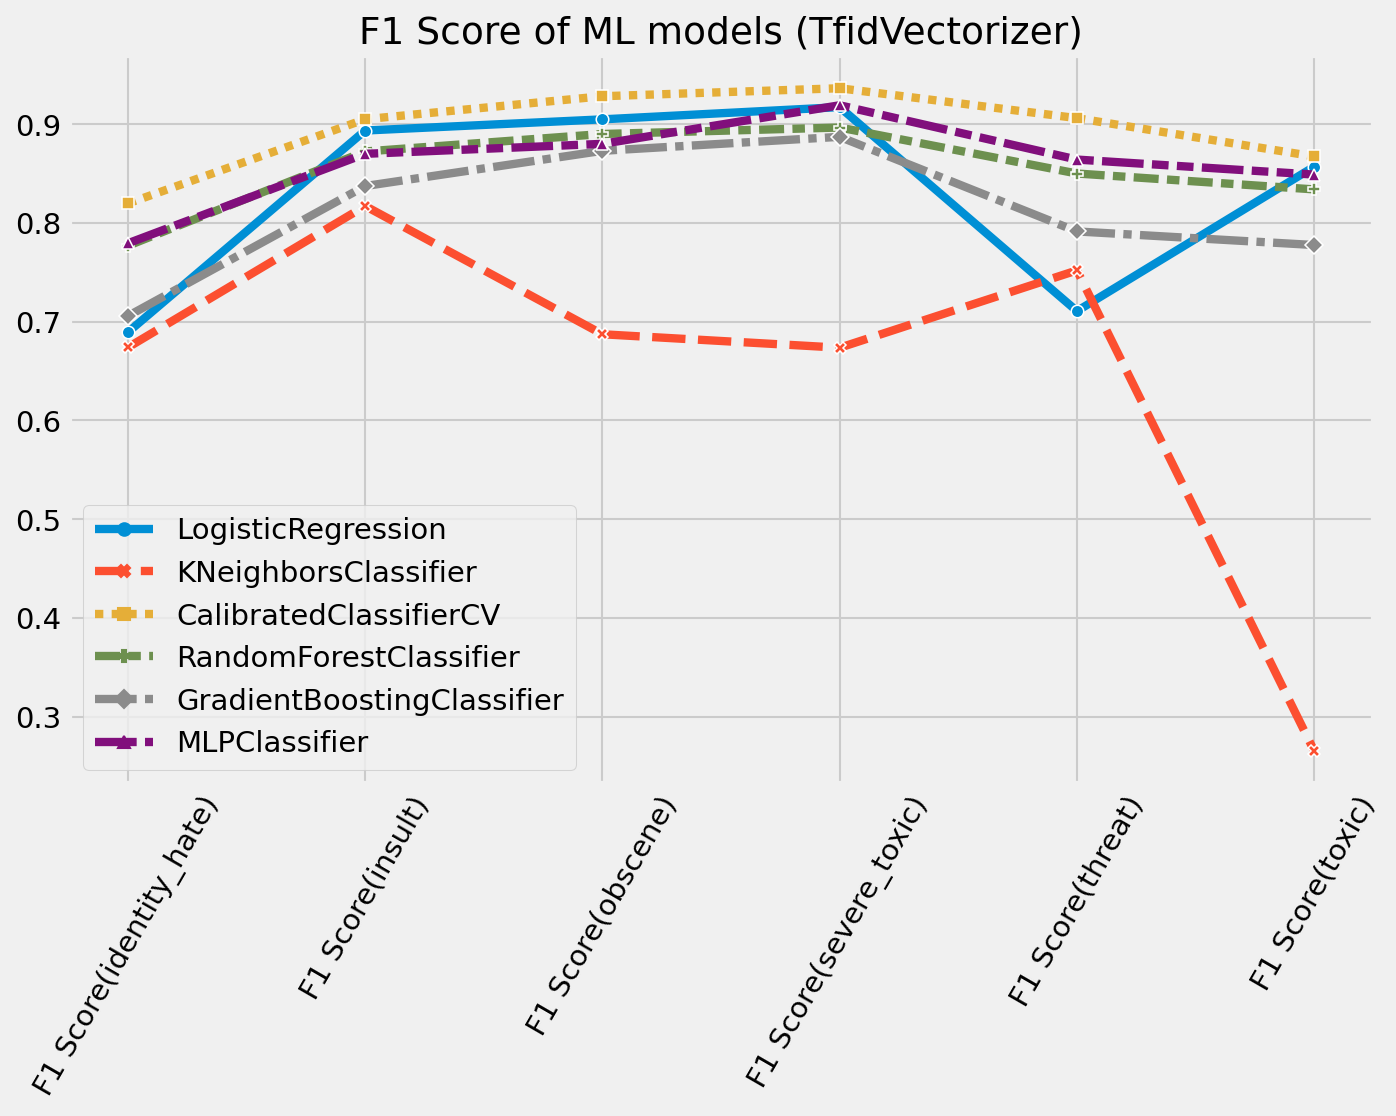

In [31]:
sns.lineplot(data=f1_all.transpose(), markers=True)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TfidVectorizer)', fontsize=18);


In [27]:
# f1_all.to_csv('./data/output/f1_scores_tfidvectorizer_results.csv')

In [29]:
f1_all_tfidvectorizer = pd.read_csv('./data/output/f1_scores_tfidvectorizer_results.csv')
f1_all_tfidvectorizer.set_index('Unnamed: 0', inplace=True)

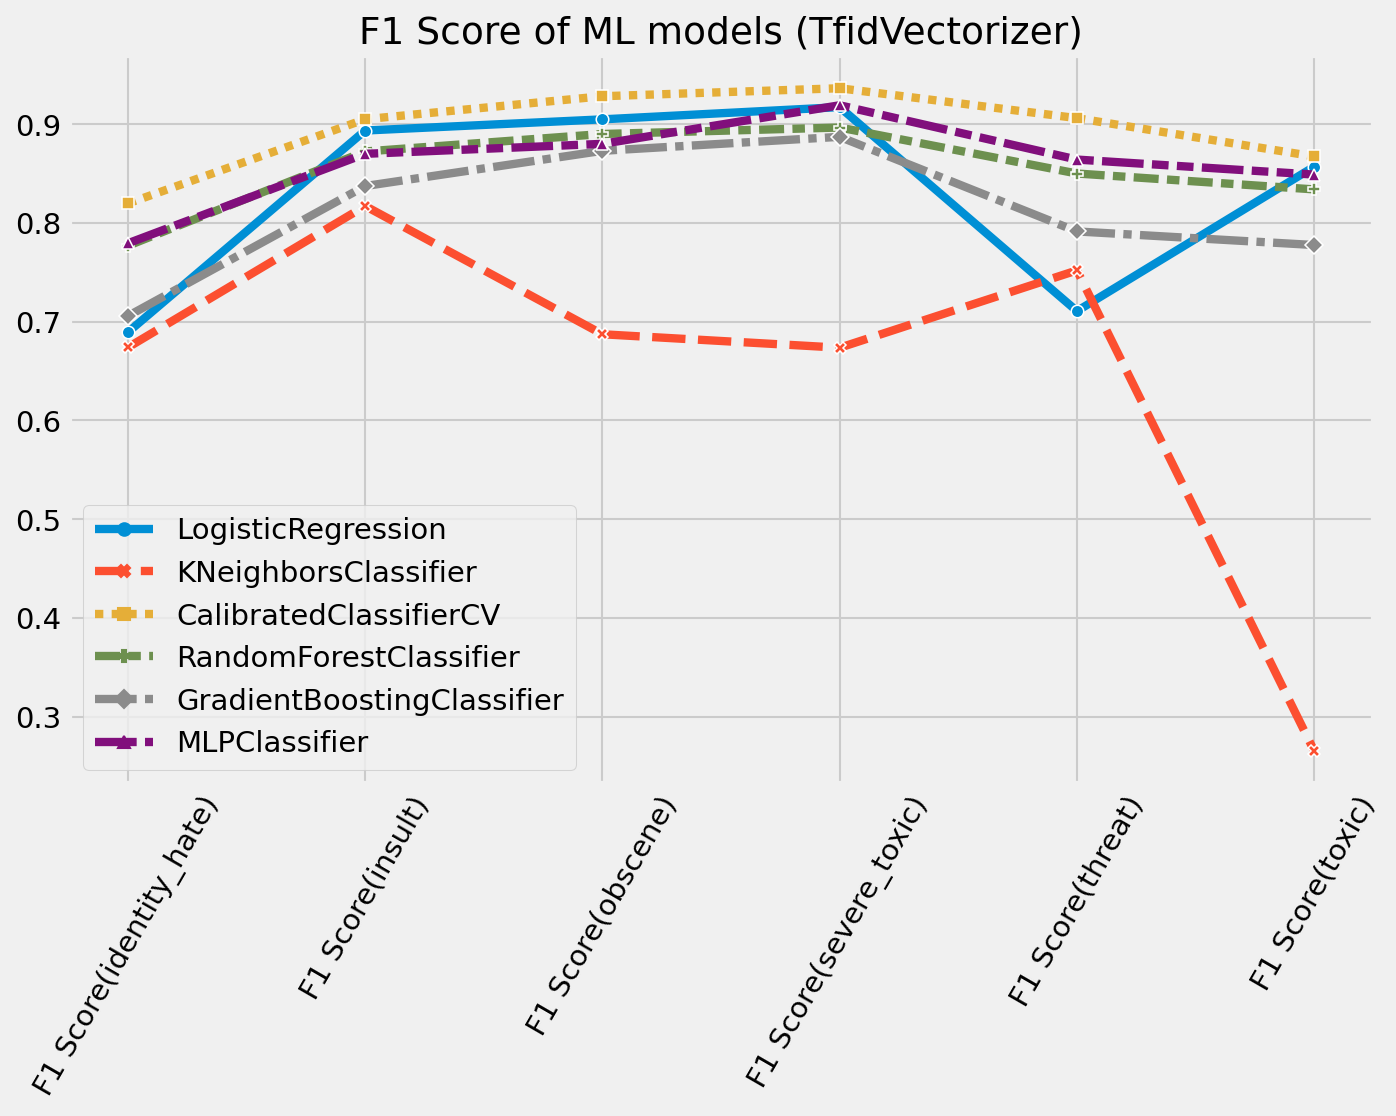

In [32]:
sns.lineplot(data=f1_all_tfidvectorizer.transpose(), markers=True)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TfidVectorizer)', fontsize=18);

### Results - Aproach #2:

- Now we see a more adequate results and we can differentiatie the model performances.
- We see that **Linear SVC + TfidVectorizer** is the overall winner in all toxic features.
    - The model performs above 90% in 4 out 6 features.
    - Better than all other models in all features
    - Interesting to see that in `toxic`, where is the most quantity robust feature, and `identity_hate`, with almost same amount as `severe_toxic`, both do below 90%.

### Aproach #3  - `CountVectorizer`

- Step 1: Split the data into X and y data sets
- Step 2: Split our data into training and test data 
- Step 3: Create a Vectorizer object and remove stopwords from the table
- Step 4 : Create an empty DataFrame 
- Step 5 : Calculate `f1_score`

In [10]:
import time

t0 = time.time()

df_tox_cv = train_test_func(data_toxic_balanced, 'toxic', CountVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time taken: 117.2593321800232 seconds


,F1 Score(toxic)
LogisticRegression,0.863636
KNeighborsClassifier,0.707617
CalibratedClassifierCV,0.657827
RandomForestClassifier,0.831642
GradientBoostingClassifier,0.765044
MLPClassifier,0.855263


In [11]:
t0 = time.time()

df_sev_cv = train_test_func(data_severe_toxic_balanced, 'severe_toxic', CountVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

Time taken: 19.61151623725891 seconds


,F1 Score(severe_toxic)
LogisticRegression,0.935622
KNeighborsClassifier,0.741270
CalibratedClassifierCV,0.628734
RandomForestClassifier,0.906344
GradientBoostingClassifier,0.889888
MLPClassifier,0.927772


In [12]:
t0 = time.time()

df_obs_cv = train_test_func(data_obscene_balanced, 'obscene', CountVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Time taken: 104.19719696044922 seconds


,F1 Score(obscene)
LogisticRegression,0.922196
KNeighborsClassifier,0.758436
CalibratedClassifierCV,0.565440
RandomForestClassifier,0.898243
GradientBoostingClassifier,0.870069
MLPClassifier,0.902973


In [13]:
t0 = time.time()

df_thr_cv = train_test_func(data_threat_balanced, 'threat', CountVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

Time taken: 11.462177038192749 seconds


,F1 Score(threat)
LogisticRegression,0.839858
KNeighborsClassifier,0.641667
CalibratedClassifierCV,0.086420
RandomForestClassifier,0.867133
GradientBoostingClassifier,0.784615
MLPClassifier,0.882155


In [14]:
t0 = time.time()

df_ins_cv = train_test_func(data_insult_balanced, 'insult', CountVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv


/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of

Time taken: 107.986163854599 seconds


,F1 Score(insult)
LogisticRegression,0.896900
KNeighborsClassifier,0.786018
CalibratedClassifierCV,0.726754
RandomForestClassifier,0.870383
GradientBoostingClassifier,0.838165
MLPClassifier,0.878927


In [15]:

t0 = time.time()

df_ide_cv = train_test_func(data_id_hate_balanced, 'identity_hate', CountVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Time taken: 64.36963105201721 seconds


,F1 Score(identity_hate)
LogisticRegression,0.772959
KNeighborsClassifier,0.640212
CalibratedClassifierCV,0.052863
RandomForestClassifier,0.769231
GradientBoostingClassifier,0.685083
MLPClassifier,0.783555


In [16]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all.style.background_gradient(cmap='Reds')

,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
LogisticRegression,0.863636,0.935622,0.922196,0.896900,0.839858,0.772959
KNeighborsClassifier,0.707617,0.741270,0.758436,0.786018,0.641667,0.640212
CalibratedClassifierCV,0.657827,0.628734,0.565440,0.726754,0.086420,0.052863
RandomForestClassifier,0.831642,0.906344,0.898243,0.870383,0.867133,0.769231
GradientBoostingClassifier,0.765044,0.889888,0.870069,0.838165,0.784615,0.685083
MLPClassifier,0.855263,0.927772,0.902973,0.878927,0.882155,0.783555


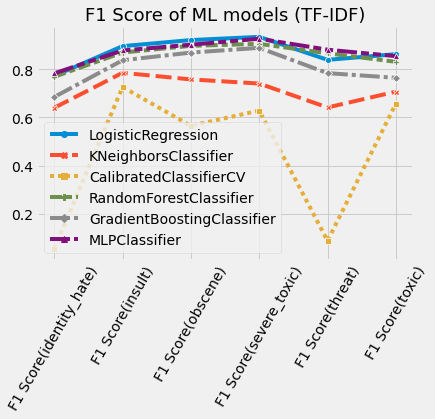

In [17]:
sns.lineplot(data=f1_all.transpose(), markers=True)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=18);

# Repeat this for CountVectorizer as well

In [18]:
# f1_all.to_csv('./data/output/f1_scores_countvectorizer_results.csv')

In [25]:
f1_all_countvect = pd.read_csv('./data/output/f1_scores_countvectorizer_results.csv')
f1_all_countvect.set_index('Unnamed: 0', inplace=ace=True)

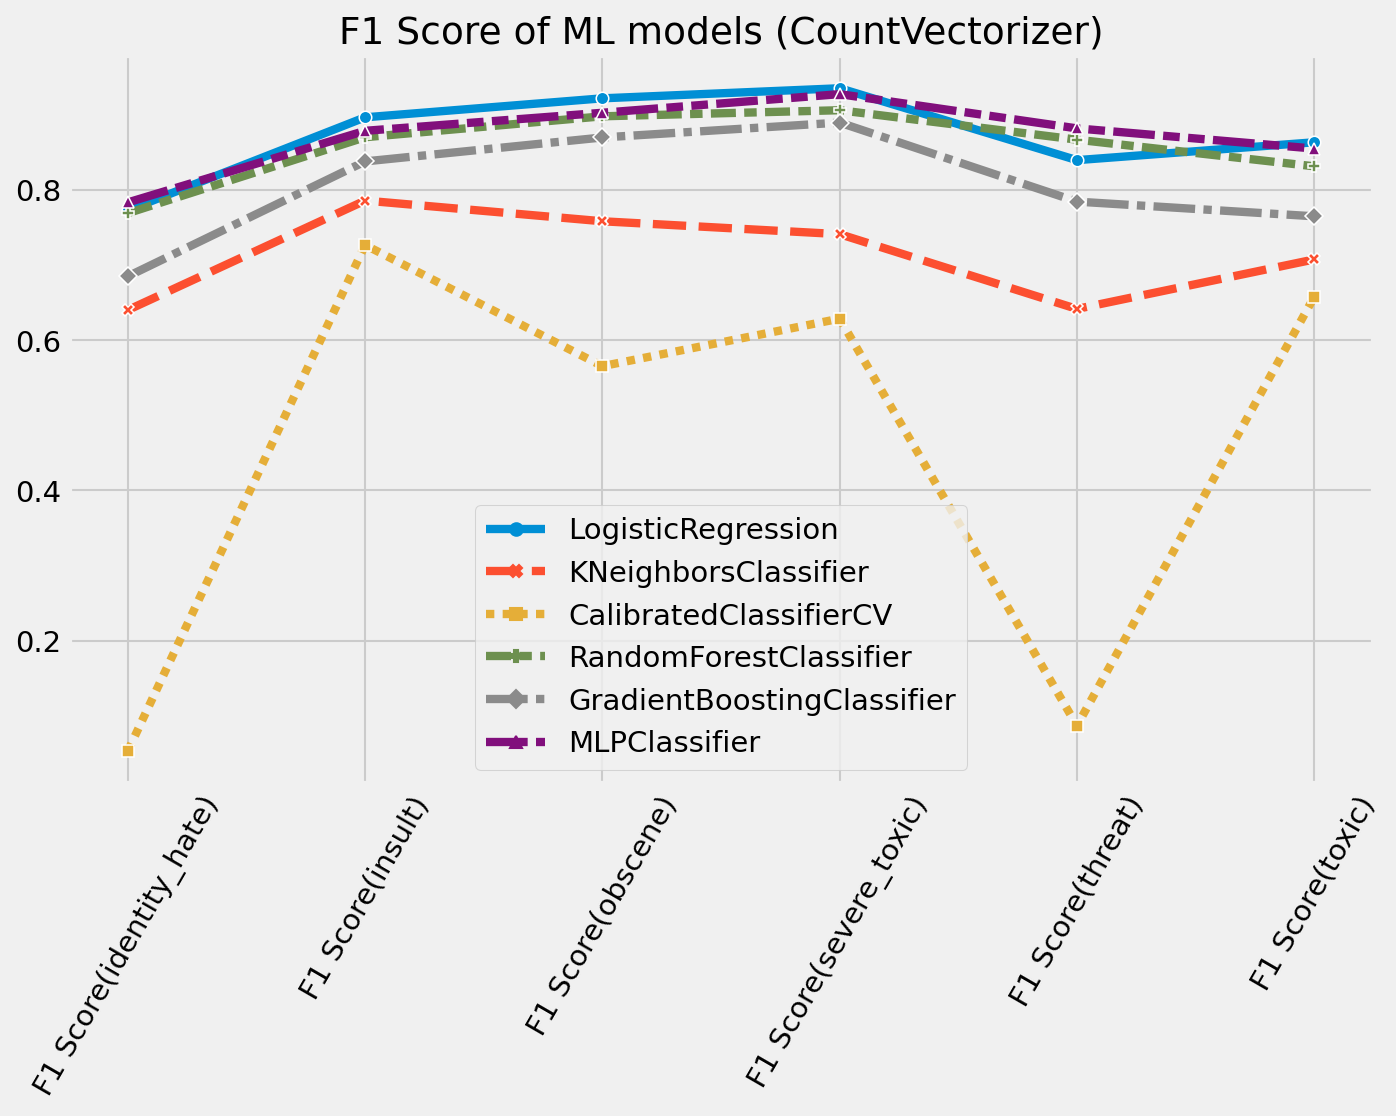

In [26]:
sns.lineplot(data=f1_all_countvect.transpose(), markers=True)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (CountVectorizer)', fontsize=18);

### Results - Approach #3:
- Overall no model does consistently better than 90%
- CountVectorizer might no be appropiate for the pre-process data.

## 6. Ensemble Model Building and Hyperparameter Tuning (NOT FINISHED)

Idea here is to use GridSearch to find the most optimize paramters for the two top models from above:
- **SVC with TfidfVectorizer**
- **MLP with CountVectorized**

Then use a VotingClassifier with both enzemble models

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [22]:
SVCpipe = Pipeline([('scale', StandardScaler(with_mean=False)),
                   ('SVC',LinearSVC())])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.arange(0.01,100,10)}
linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)


# Split the data into X and y data sets
X = data_toxic_balanced.comment_text
y = data_toxic_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

# grid_clf = GridSearchCV(LinearSVC() , {
#     'C' : [1.0,20.0,30.0],
#     'kernel' : ['rbf', 'linear']

# },cv = 5, return_train_score=False)

linearSVC.fit(X_train_fit, y_train)
print(linearSVC.best_params_)

/Users/cristobalza/opt/anaconda3/envs/santiago-projects/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'SVC__C': 0.01}


In [23]:
linearSVC.best_estimator_

Pipeline(steps=[('scale', StandardScaler(with_mean=False)),
                ('SVC', LinearSVC(C=0.01))])

## 7. Test Model Results 

Let's compare the different models so far with simple phrases and only choosing a feature to predict.

##### SVC with TfidfVectorizer

In [40]:
X = data_toxic_balanced.comment_text
y = data_toxic_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

model = LinearSVC()
clf = CalibratedClassifierCV(model) # in case of SVM Family
model = clf

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
model.fit(X_train_fit, y_train)
model.predict(X_test_fit)

array([1, 1, 1, ..., 1, 0, 1])

In [41]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ["Luke, I'm your papacito and I hope the force be with you tomorrow can be or maybe not life"]

comment1_vect = tfv.transform(comment1)
model.predict_proba(comment1_vect)[:,1]

array([0.99999201])

In [42]:
comment2_vect = tfv.transform(comment2)
model.predict_proba(comment2_vect)[:,1]

array([0.59831782])

##### MLP with CountVectorized

In [43]:
X = data_toxic_balanced.comment_text
y = data_toxic_balanced['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate vectorizer
tfv = CountVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

model = MLPClassifier()
# clf = CalibratedClassifierCV(model) # in case of SVM Family
# model = clf

# Train our  model with the X training data converted into Count Vectorized format with the Y training data
model.fit(X_train_fit, y_train)
model.predict(X_test_fit)

array([1, 1, 1, ..., 1, 0, 1])

In [38]:
# Sample Prediction
comment1 = ['You are a piece of shit']
comment2 = ["Luke, I'm your papacito and I hope the force be with you tomorrow can be or maybe not life"]

comment1_vect = tfv.transform(comment1)
model.predict_proba(comment1_vect)[:,1]

array([0.99981998])

In [39]:
comment2_vect = tfv.transform(comment2)
model.predict_proba(comment2_vect)[:,1]

array([0.91589879])

## 8. Deploy

Use `pickle` to save the machine learning model in a binary object so that we don't have to -retrain the model everytime you use your work.

> *Useful when something required a lot of process and ends up in an object. - [sentdex Youtube Video](https://youtu.be/2Tw39kZIbhs)*

In [24]:
import pickle

In [34]:
def export_model_func(df, label):
    
    X = df.comment_text
    y = df[label]

    vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    X_vect = vectorizer.fit_transform(X)  
    
    # saves the column labels (ie. the vocabulary)
    # wb means Writing to the file in Binary mode, written in byte objects
    with open(r"./models/{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(vectorizer, f)   
        
    # BEST MODEL    
    model = LinearSVC()
    clf = CalibratedClassifierCV(model) # in case of SVM Family
    model = clf
    model.fit(X_vect, y)

    # Create a new pickle file based on the best model
    with open(r"./models/{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(model, f)

In [35]:
features = ['toxic',
            'severe_toxic',
            'obscene',
            'threat',
            'insult',
            'identity_hate']
datasets = [data_toxic_balanced,
            data_severe_toxic_balanced,
            data_obscene_balanced,
            data_threat_balanced,
            data_insult_balanced,
            data_id_hate_balanced]

In [36]:
for data, toxic_feature in zip(datasets, features):
    export_model_func(data, toxic_feature)